*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

# Chunking an Image Dataset for Minibatch Training using NumPy NPZ Archives

This notebook provides an example for how to organize a large dataset of images into chunks for quick access during minibatch learning. This approach uses NumPy .npz archive files and only requires having NumPy as a dependency so that this approach should be compatible with different Python-based machine learning and deep learning libraries and packages for further image (pre)processing and augmentation. 

While this approach performs reasonably well (sufficiently well for my applications), you may also be interested in TensorFlow's "[Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)" guide to work with `TfRecords` and file queues.


## 0. The Dataset

Let's pretend we have a directory of images containing two subdirectories with images for training, validation, and testing. The following function will create such a dataset of images in PNG format locally for demonstration purposes.

In [1]:
# Note that executing the following code 
# cell will download the MNIST dataset
# and save all the 60,000 images as separate PNG
# files. This might take a few minutes depending
# on your machine.

from helper import mnist_export_to_jpg

mnist_export_to_jpg(path='./')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [2]:
import os

for i in ('train', 'valid', 'test'):
    print('mnist_%s subdirectories' % i, os.listdir('mnist_%s' % i))

mnist_train subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_valid subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_test subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Note that the names of the subdirectories correspond directly to the class label of the images that are stored under it.

To make sure that the images look okay, the snippet below plots an example image from the subdirectory `mnist_train/9/`:

(28, 28)


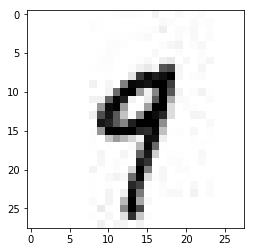

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('./mnist_train/9/1004.jpg')
print(img.shape)
plt.imshow(img, cmap='binary');

Note: The JPEG format introduces a few artifacts that we can see in the image above. In this case, we use JPEG instead of PNG. Here, JPEG is used for demonstration purposes since that's still format many image datasets are stored in.

## 1. Chunking Images into NumPy NPZ Archive Files

The following wrapper function creates .npz archive files training, testing, and validation. It will group images together into integer arrays that are then saved as .npz archive files. The number of rows (images) in each .npz archive will be equal to the `archive_size` argument. 

In [4]:
import numpy as np
import glob


def images_to_pickles(data_stempath='./mnist_', which_set='train', 
                      archive_size=5000, width=28, height=28, channels=1,
                      shuffle=False, seed=None):
    
    if not os.path.exists('%snpz' % data_stempath):
        os.mkdir('%snpz' % data_stempath)
        
    img_paths = [p for p in glob.iglob('%s%s/**/*.jpg' % 
                                   (data_stempath, which_set), recursive=True)]
    if shuffle:
        rgen = np.random.RandomState(seed)
        paths = rgen.shuffle(img_paths)
    
    idx, file_idx = 0, 1
    data = np.zeros((archive_size, height, width, channels), dtype=np.uint8)
    labels = np.zeros(archive_size, dtype=np.uint8)
    for path in img_paths:
        if idx >= archive_size - 1:
            idx = 0
            savepath = os.path.join('%snpz' % data_stempath, '%s_%d.npz' % 
                                    (which_set, file_idx))
            file_idx += 1
            np.savez(savepath, data=data, labels=labels)

        label = int(os.path.basename(os.path.dirname(path)))
        image = mpimg.imread(path)
        
        if len(image.shape) == 2:
            data[idx] = image[:, :, np.newaxis]
        labels[idx] = label
        idx += 1

In [5]:
images_to_pickles(which_set='train', shuffle=True, seed=1)
images_to_pickles(which_set='valid', shuffle=True, seed=1)
images_to_pickles(which_set='test', shuffle=True, seed=1)

The .npz files we created are stored under a new directory, `mnist_npz`:

In [6]:
import os

os.listdir('mnist_npz')

['test_1.npz',
 'test_2.npz',
 'train_1.npz',
 'train_2.npz',
 'train_3.npz',
 'train_4.npz',
 'train_5.npz',
 'train_6.npz',
 'train_7.npz',
 'train_8.npz',
 'train_9.npz',
 'valid_1.npz']

To check that the archiving worked correctly, we will now load one of those .npz archives. Note that we can now access each archive just like a python dictionary. Here the `'data'` key contains the image data and the `'labels'` key stores an array containing the corresponding class labels:

In [7]:
data = np.load('mnist_npz/test_1.npz')
print(data['data'].shape)
print(data['labels'].shape)

(5000, 28, 28, 1)
(5000,)


Class label: 9


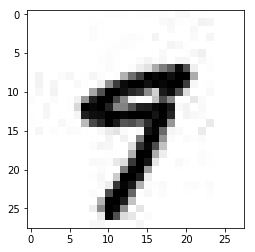

In [8]:
plt.imshow(data['data'][0][:, :, -1], cmap='binary');
print('Class label:', data['labels'][0])

## 2. Loading Minibatches

The following cell implements a class for iterating over the MNIST images, based on the .npz archives, conveniently. 
Via the `normalize` parameter we additionally scale the image pixels to [0, 1] range, which typically helps with gradient-based optimization in practice.

The key functions (here: generators) are

- load_train_epoch
- load_valid_epoch
- load_test_epoch

These let us iterate over small chunks (determined via `minibatch_size`). Each of these functions will load the images from a particular .npz archive into memory (here: 5000 images) and yield minibatches of smaller or equal size (for example, 50 images at a time). Via the two shuffle parameters, we can further control if the images within each .npz archive should be shuffled, and if the order the .npz files are loaded should shuffled after each epoch. By setting `onehot=True`, the labels are converted into a onehot representation for convenience.

In [9]:
class BatchLoader():
    def __init__(self, minibatches_path, 
                 normalize=True):
        
        self.normalize = normalize

        self.train_batchpaths = [os.path.join(minibatches_path, f)
                                 for f in os.listdir(minibatches_path)
                                 if 'train' in f]
        self.valid_batchpaths = [os.path.join(minibatches_path, f)
                                 for f in os.listdir(minibatches_path)
                                 if 'valid' in f]
        self.test_batchpaths = [os.path.join(minibatches_path, f)
                                 for f in os.listdir(minibatches_path)
                                 if 'train' in f]

        self.num_train = 45000
        self.num_valid = 5000
        self.num_test = 10000
        self.n_classes = 10


    def load_train_epoch(self, batch_size=50, onehot=False,
                         shuffle_within=False, shuffle_paths=False,
                         seed=None):
        for batch_x, batch_y in self._load_epoch(which='train',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_within=shuffle_within,
                                                 shuffle_paths=shuffle_paths,
                                                 seed=seed):
            yield batch_x, batch_y

    def load_test_epoch(self, batch_size=50, onehot=False,
                        shuffle_within=False, shuffle_paths=False, 
                        seed=None):
        for batch_x, batch_y in self._load_epoch(which='test',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_within=shuffle_within,
                                                 shuffle_paths=shuffle_paths,
                                                 seed=seed):
            yield batch_x, batch_y
            
    def load_validation_epoch(self, batch_size=50, onehot=False,
                         shuffle_within=False, shuffle_paths=False, 
                         seed=None):
        for batch_x, batch_y in self._load_epoch(which='valid',
                                                 batch_size=batch_size,
                                                 onehot=onehot,
                                                 shuffle_within=shuffle_within,
                                                 shuffle_paths=shuffle_paths,
                                                 seed=seed):
            yield batch_x, batch_y

    def _load_epoch(self, which='train', batch_size=50, onehot=False,
                    shuffle_within=True, shuffle_paths=True, seed=None):

        if which == 'train':
            paths = self.train_batchpaths
        elif which == 'valid':
            paths = self.valid_batchpaths
        elif which == 'test':
            paths = self.test_batchpaths
        else:
            raise ValueError('`which` must be "train" or "test". Got %s.' %
                             which)
            
        rgen = np.random.RandomState(seed)
        if shuffle_paths:
            pass
            #paths = rgen.shuffle(paths)

        for batch in paths:

            dct = np.load(batch)

            if onehot:
                labels = (np.arange(self.n_classes) == 
                          dct['labels'][:, None]).astype(np.uint8)
            else:
                labels = dct['labels']

            if self.normalize:
                # normalize to [0, 1] range
                data = dct['data'].astype(np.float32) / 255.
            else:
                data = dct['data']

            arrays = [data, labels]
            del dct
            indices = np.arange(arrays[0].shape[0])

            if shuffle_within:
                rgen.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - batch_size + 1,
                                   batch_size):
                index_slice = indices[start_idx:start_idx + batch_size]
                yield (ary[index_slice] for ary in arrays)

The following for loop will iterate over the 45,000 training examples in our MNIST training set, yielding 50 images and labels at a time (note that we previously set aside 5000 training example as our validation datast).

In [10]:
batch_loader = BatchLoader(minibatches_path='./mnist_npz/', 
                           normalize=True)

for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=50, onehot=True):
    print(batch_x.shape)
    print(batch_y.shape)
    break

(50, 28, 28, 1)
(50, 10)


In [11]:
cnt = 0
for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=50, onehot=True):
    cnt += batch_x.shape[0]
    
print('One training epoch contains %d images' % cnt)

One training epoch contains 45000 images


In [12]:
def one_epoch():
    for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=50, onehot=True):
        pass
    
% timeit one_epoch()

330 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see from the benchmark above, an iteration over one training epoch (45k images) is relatively fast.

Similarly, we could iterate over validation and test data via 

- batch_loader.load_validation_epoch
- batch_loader.load_test_epoch

## 3. Training a Model using TensorFlow's `feed_dict`

The following code demonstrate how we can feed our minibatches into a TensorFlow graph using a TensorFlow session's `feed_dict`.

### Multilayer Perceptron Graph

In [13]:
import tensorflow as tf

##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.1
training_epochs = 15
batch_size = 100

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():

    # Input data
    tf_x = tf.placeholder(tf.float32, [None, height, width, 1], name='features')
    tf_x_flat = tf.reshape(tf_x, shape=[-1, height*width])
    tf_y = tf.placeholder(tf.int32, [None, n_classes], name='targets')

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([width*height, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_x_flat, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=tf_y)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    correct_prediction = tf.equal(tf.argmax(tf_y, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### Training the Neural Network with Minibatches

In [14]:
##########################
### TRAINING & EVALUATION
##########################

batch_loader = BatchLoader(minibatches_path='./mnist_npz/', 
                           normalize=True)

# preload small validation set
# by unpacking the generator
[valid_data] = batch_loader.load_validation_epoch(batch_size=5000, 
                                                   onehot=True)
valid_x, valid_y = valid_data[0], valid_data[1]
del valid_data

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        avg_cost = 0.

        n_batches = 0
        for batch_x, batch_y in batch_loader.load_train_epoch(batch_size=batch_size, 
                                                              onehot=True, 
                                                              seed=epoch):
            n_batches += 1
            _, c = sess.run(['train', 'cost:0'], feed_dict={'features:0': batch_x,
                                                            'targets:0': batch_y.astype(np.int)})
            avg_cost += c
        
        train_acc = sess.run('accuracy:0', feed_dict={'features:0': batch_x,
                                                      'targets:0': batch_y})
        
        valid_acc = sess.run('accuracy:0', feed_dict={'features:0': valid_x,
                                                      'targets:0': valid_y})  
        
        print("Epoch: %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / n_batches), end="")
        print(" | MbTrain/Valid ACC: %.3f/%.3f" % (train_acc, valid_acc))
        
        
    # imagine test set is too large to fit into memory:
    test_acc, cnt = 0., 0
    for test_x, test_y in batch_loader.load_test_epoch(batch_size=100, 
                                                         onehot=True):   
        cnt += 1
        acc = sess.run(accuracy, feed_dict={'features:0': test_x,
                                            'targets:0': test_y})
        test_acc += acc
    print('Test ACC: %.3f' % (test_acc / cnt))

Epoch: 001 | AvgCost: 0.445 | MbTrain/Valid ACC: 0.940/0.922
Epoch: 002 | AvgCost: 0.213 | MbTrain/Valid ACC: 0.960/0.943
Epoch: 003 | AvgCost: 0.158 | MbTrain/Valid ACC: 0.970/0.951
Epoch: 004 | AvgCost: 0.126 | MbTrain/Valid ACC: 0.970/0.957
Epoch: 005 | AvgCost: 0.105 | MbTrain/Valid ACC: 0.980/0.960
Epoch: 006 | AvgCost: 0.090 | MbTrain/Valid ACC: 0.980/0.962
Epoch: 007 | AvgCost: 0.077 | MbTrain/Valid ACC: 0.980/0.965
Epoch: 008 | AvgCost: 0.067 | MbTrain/Valid ACC: 0.980/0.966
Epoch: 009 | AvgCost: 0.059 | MbTrain/Valid ACC: 0.980/0.967
Epoch: 010 | AvgCost: 0.052 | MbTrain/Valid ACC: 0.980/0.968
Epoch: 011 | AvgCost: 0.046 | MbTrain/Valid ACC: 0.980/0.967
Epoch: 012 | AvgCost: 0.040 | MbTrain/Valid ACC: 0.980/0.967
Epoch: 013 | AvgCost: 0.036 | MbTrain/Valid ACC: 0.990/0.967
Epoch: 014 | AvgCost: 0.032 | MbTrain/Valid ACC: 1.000/0.968
Epoch: 015 | AvgCost: 0.028 | MbTrain/Valid ACC: 1.000/0.968
Test ACC: 0.994
